# Mixture Density Network 

Reproducing the classic Bishop MDN network tasks in Keras.

In [31]:
import keras
from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf

class MDN(Layer):
    """A Mixture Density Network Layer for Keras."""
    
    def __init__(self, output_dim, num_mix, **kwargs):
        self.output_dim = output_dim
        self.num_mix = num_mix
        with tf.name_scope('MDN'):
            self.mdn_mus     = Dense(self.num_mix * self.output_dim, name='mdn_mus') # mix*output vals, no activation
            self.mdn_sigmas  = Dense(self.num_mix * self.output_dim, activation=K.exp, name='mdn_sigmas') # mix*output vals exp activation
            self.mdn_pi      = Dense(self.num_mix, activation=K.softmax, name='mdn_pi') # mix vals, softmax
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)
        
    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x), 
                                                self.mdn_sigmas(x), 
                                                self.mdn_pi(x)], 
                                               name='mdn_outputs')
        return mdn_out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        return loss
    
    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func
    
def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
        
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func
    
def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer 
    that takes one sample and compares to the true value."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func

## Generate Synthetic Data

Data generation



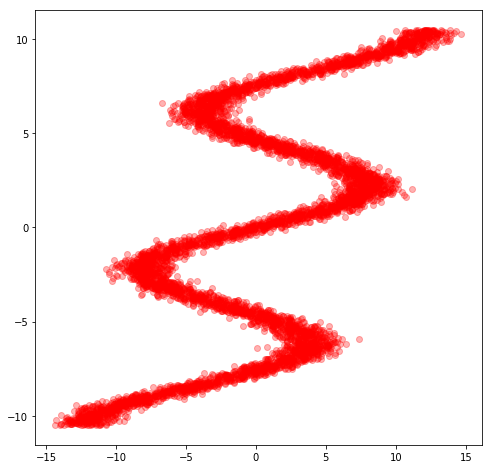

In [33]:
import matplotlib.pyplot as plt

## Generating some data:

NSAMPLE = 6000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [45]:
model = keras.Sequential()
model.add(keras.layers.Dense(24, batch_input_shape=(None, 1), activation='tanh'))
model.add(MDN(1, 10))
model.compile(loss=get_mixture_loss_func(1,10), optimizer=keras.optimizers.Adam()) #, metrics=[get_mixture_mse_accuracy(1,3)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 24)                48        
_________________________________________________________________
mdn_7 (MDN)                  (None, 1)                 750       
Total params: 798
Trainable params: 798
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x=x_data, y=y_data, batch_size=64, epochs=3000, validation_split=0.1)

Train on 5400 samples, validate on 600 samples
Epoch 1/3000
5400/5400 [==============================] - 2s 441us/step - loss: 4.7016 - val_loss: 4.0163
Epoch 2/3000
5400/5400 [==============================] - 0s 59us/step - loss: 3.7758 - val_loss: 3.6593
Epoch 3/3000
5400/5400 [==============================] - 0s 59us/step - loss: 3.5534 - val_loss: 3.5256
Epoch 4/3000
5400/5400 [==============================] - 0s 59us/step - loss: 3.4411 - val_loss: 3.4268
Epoch 5/3000
5400/5400 [==============================] - 0s 59us/step - loss: 3.3594 - val_loss: 3.3539
Epoch 6/3000
5400/5400 [==============================] - 0s 60us/step - loss: 3.2922 - val_loss: 3.2998
Epoch 7/3000
5400/5400 [==============================] - 0s 59us/step - loss: 3.2226 - val_loss: 3.2343
Epoch 8/3000
5400/5400 [==============================] - 0s 60us/step - loss: 3.1860 - val_loss: 3.2127
Epoch 9/3000
5400/5400 [==============================] - 0s 60us/step - loss: 3.1578 - val_loss: 3.1748
Epoch 1

Epoch 78/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0810 - val_loss: 2.1638
Epoch 79/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0768 - val_loss: 2.1614
Epoch 80/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0773 - val_loss: 2.1598
Epoch 81/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0761 - val_loss: 2.1518
Epoch 82/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0743 - val_loss: 2.1606
Epoch 83/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0718 - val_loss: 2.1447
Epoch 84/3000
5400/5400 [==============================] - 0s 59us/step - loss: 2.0688 - val_loss: 2.1493
Epoch 85/3000
5400/5400 [==============================] - 0s 58us/step - loss: 2.0688 - val_loss: 2.1563
Epoch 86/3000
5400/5400 [==============================] - 0s 59us/step - loss: 2.0667 - val_loss: 2.1523
Epoch 87/3000
5400/5400 [=====================

Epoch 155/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8236 - val_loss: 1.8764
Epoch 156/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8233 - val_loss: 1.8665
Epoch 157/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.8217 - val_loss: 1.8753
Epoch 158/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8198 - val_loss: 1.8767
Epoch 159/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8190 - val_loss: 1.8998
Epoch 160/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.8219 - val_loss: 1.8668
Epoch 161/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8152 - val_loss: 1.8549
Epoch 162/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8165 - val_loss: 1.8650
Epoch 163/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.8180 - val_loss: 1.8511
Epoch 164/3000
5400/5400 [===========

5400/5400 [==============================] - 0s 58us/step - loss: 1.7414 - val_loss: 1.7823
Epoch 232/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7375 - val_loss: 1.7851
Epoch 233/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7383 - val_loss: 1.7909
Epoch 234/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7386 - val_loss: 1.8030
Epoch 235/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7418 - val_loss: 1.7925
Epoch 236/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7370 - val_loss: 1.7966
Epoch 237/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.7383 - val_loss: 1.7842
Epoch 238/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7343 - val_loss: 1.7849
Epoch 239/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.7376 - val_loss: 1.7956
Epoch 240/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 59us/step - loss: 1.6979 - val_loss: 1.7699
Epoch 308/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6999 - val_loss: 1.7511
Epoch 309/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6984 - val_loss: 1.7394
Epoch 310/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6969 - val_loss: 1.7481
Epoch 311/3000
5400/5400 [==============================] - 0s 92us/step - loss: 1.6965 - val_loss: 1.7478
Epoch 312/3000
5400/5400 [==============================] - 0s 90us/step - loss: 1.6977 - val_loss: 1.7439
Epoch 313/3000
5400/5400 [==============================] - 0s 62us/step - loss: 1.6955 - val_loss: 1.7577
Epoch 314/3000
5400/5400 [==============================] - 0s 74us/step - loss: 1.6971 - val_loss: 1.7637
Epoch 315/3000
5400/5400 [==============================] - 0s 84us/step - loss: 1.6986 - val_loss: 1.7461
Epoch 316/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 66us/step - loss: 1.6841 - val_loss: 1.7451
Epoch 384/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6820 - val_loss: 1.7436
Epoch 385/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6834 - val_loss: 1.7373
Epoch 386/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6822 - val_loss: 1.7468
Epoch 387/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6832 - val_loss: 1.7360
Epoch 388/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6808 - val_loss: 1.7351
Epoch 389/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6825 - val_loss: 1.7468
Epoch 390/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6809 - val_loss: 1.7453
Epoch 391/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6854 - val_loss: 1.7437
Epoch 392/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6768 - val_loss: 1.7484
Epoch 460/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6769 - val_loss: 1.7478
Epoch 461/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6751 - val_loss: 1.7413
Epoch 462/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6772 - val_loss: 1.7419
Epoch 463/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6759 - val_loss: 1.7441
Epoch 464/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6757 - val_loss: 1.7543
Epoch 465/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6755 - val_loss: 1.7493
Epoch 466/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6782 - val_loss: 1.7525
Epoch 467/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6756 - val_loss: 1.7400
Epoch 468/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6699 - val_loss: 1.7558
Epoch 536/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6740 - val_loss: 1.7529
Epoch 537/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6724 - val_loss: 1.7561
Epoch 538/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6734 - val_loss: 1.7377
Epoch 539/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6717 - val_loss: 1.7578
Epoch 540/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6712 - val_loss: 1.7453
Epoch 541/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6728 - val_loss: 1.7472
Epoch 542/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6742 - val_loss: 1.7308
Epoch 543/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6721 - val_loss: 1.7453
Epoch 544/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6700 - val_loss: 1.7498
Epoch 612/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6705 - val_loss: 1.7494
Epoch 613/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6689 - val_loss: 1.7348
Epoch 614/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6678 - val_loss: 1.7468
Epoch 615/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6689 - val_loss: 1.7539
Epoch 616/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6703 - val_loss: 1.7542
Epoch 617/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6683 - val_loss: 1.7581
Epoch 618/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6694 - val_loss: 1.7535
Epoch 619/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6682 - val_loss: 1.7417
Epoch 620/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6669 - val_loss: 1.7569
Epoch 688/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6651 - val_loss: 1.7381
Epoch 689/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6645 - val_loss: 1.7455
Epoch 690/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6690 - val_loss: 1.7498
Epoch 691/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6682 - val_loss: 1.7522
Epoch 692/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6641 - val_loss: 1.7532
Epoch 693/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6714 - val_loss: 1.7413
Epoch 694/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6663 - val_loss: 1.7702
Epoch 695/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6653 - val_loss: 1.7431
Epoch 696/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 58us/step - loss: 1.6655 - val_loss: 1.7456
Epoch 764/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6625 - val_loss: 1.7384
Epoch 765/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6660 - val_loss: 1.7529
Epoch 766/3000
5400/5400 [==============================] - 0s 64us/step - loss: 1.6635 - val_loss: 1.7448
Epoch 767/3000
5400/5400 [==============================] - 0s 62us/step - loss: 1.6650 - val_loss: 1.7473
Epoch 768/3000
5400/5400 [==============================] - 0s 62us/step - loss: 1.6630 - val_loss: 1.7373
Epoch 769/3000
5400/5400 [==============================] - 0s 63us/step - loss: 1.6651 - val_loss: 1.7415
Epoch 770/3000
5400/5400 [==============================] - 0s 91us/step - loss: 1.6664 - val_loss: 1.7551
Epoch 771/3000
5400/5400 [==============================] - 0s 72us/step - loss: 1.6626 - val_loss: 1.7391
Epoch 772/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6608 - val_loss: 1.7457
Epoch 840/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6594 - val_loss: 1.7558
Epoch 841/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6586 - val_loss: 1.7461
Epoch 842/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6615 - val_loss: 1.7413
Epoch 843/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6612 - val_loss: 1.7620
Epoch 844/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6621 - val_loss: 1.7486
Epoch 845/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6588 - val_loss: 1.7467
Epoch 846/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6587 - val_loss: 1.7422
Epoch 847/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6588 - val_loss: 1.7526
Epoch 848/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6573 - val_loss: 1.7501
Epoch 916/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6602 - val_loss: 1.7465
Epoch 917/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6588 - val_loss: 1.7562
Epoch 918/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6556 - val_loss: 1.7459
Epoch 919/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6580 - val_loss: 1.7449
Epoch 920/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6619 - val_loss: 1.7439
Epoch 921/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6588 - val_loss: 1.7421
Epoch 922/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6591 - val_loss: 1.7443
Epoch 923/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6564 - val_loss: 1.7401
Epoch 924/3000
5400/5400 [==========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6532 - val_loss: 1.7387
Epoch 992/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6548 - val_loss: 1.7419
Epoch 993/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6547 - val_loss: 1.7304
Epoch 994/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6537 - val_loss: 1.7398
Epoch 995/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6557 - val_loss: 1.7361
Epoch 996/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6570 - val_loss: 1.7420
Epoch 997/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6527 - val_loss: 1.7314
Epoch 998/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6548 - val_loss: 1.7326
Epoch 999/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6568 - val_loss: 1.7430
Epoch 1000/3000
5400/5400 [=========================

5400/5400 [==============================] - 0s 56us/step - loss: 1.6503 - val_loss: 1.7348
Epoch 1068/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6503 - val_loss: 1.7403
Epoch 1069/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6486 - val_loss: 1.7420
Epoch 1070/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6485 - val_loss: 1.7317
Epoch 1071/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6530 - val_loss: 1.7408
Epoch 1072/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6501 - val_loss: 1.7300
Epoch 1073/3000
5400/5400 [==============================] - 0s 56us/step - loss: 1.6511 - val_loss: 1.7408
Epoch 1074/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6497 - val_loss: 1.7506
Epoch 1075/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6506 - val_loss: 1.7371
Epoch 1076/3000
5400/5400 [=================

Epoch 1143/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6450 - val_loss: 1.7299
Epoch 1144/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6465 - val_loss: 1.7309
Epoch 1145/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6478 - val_loss: 1.7340
Epoch 1146/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6470 - val_loss: 1.7326
Epoch 1147/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6479 - val_loss: 1.7334
Epoch 1148/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6458 - val_loss: 1.7434
Epoch 1149/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6472 - val_loss: 1.7428
Epoch 1150/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6466 - val_loss: 1.7358
Epoch 1151/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6455 - val_loss: 1.7472
Epoch 1152/3000
5400/5400 [=

Epoch 1219/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6455 - val_loss: 1.7247
Epoch 1220/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6456 - val_loss: 1.7504
Epoch 1221/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6456 - val_loss: 1.7303
Epoch 1222/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6458 - val_loss: 1.7309
Epoch 1223/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6445 - val_loss: 1.7345
Epoch 1224/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6451 - val_loss: 1.7372
Epoch 1225/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6451 - val_loss: 1.7426
Epoch 1226/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6453 - val_loss: 1.7309
Epoch 1227/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6442 - val_loss: 1.7306
Epoch 1228/3000
5400/5400 [=

Epoch 1295/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6429 - val_loss: 1.7423
Epoch 1296/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6436 - val_loss: 1.7388
Epoch 1297/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6462 - val_loss: 1.7239
Epoch 1298/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6429 - val_loss: 1.7312
Epoch 1299/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6434 - val_loss: 1.7265
Epoch 1300/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6427 - val_loss: 1.7336
Epoch 1301/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6427 - val_loss: 1.7312
Epoch 1302/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6434 - val_loss: 1.7303
Epoch 1303/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6421 - val_loss: 1.7265
Epoch 1304/3000
5400/5400 [=

Epoch 1371/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6413 - val_loss: 1.7345
Epoch 1372/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6431 - val_loss: 1.7423
Epoch 1373/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6417 - val_loss: 1.7258
Epoch 1374/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6428 - val_loss: 1.7312
Epoch 1375/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6450 - val_loss: 1.7333
Epoch 1376/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6417 - val_loss: 1.7315
Epoch 1377/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6399 - val_loss: 1.7429
Epoch 1378/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6438 - val_loss: 1.7394
Epoch 1379/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6419 - val_loss: 1.7321
Epoch 1380/3000
5400/5400 [=

Epoch 1447/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6416 - val_loss: 1.7327
Epoch 1448/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6382 - val_loss: 1.7331
Epoch 1449/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6401 - val_loss: 1.7342
Epoch 1450/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6399 - val_loss: 1.7258
Epoch 1451/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6458 - val_loss: 1.7389
Epoch 1452/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6410 - val_loss: 1.7263
Epoch 1453/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6417 - val_loss: 1.7335
Epoch 1454/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6397 - val_loss: 1.7372
Epoch 1455/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6421 - val_loss: 1.7369
Epoch 1456/3000
5400/5400 [=

Epoch 1523/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6398 - val_loss: 1.7325
Epoch 1524/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6393 - val_loss: 1.7335
Epoch 1525/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6377 - val_loss: 1.7337
Epoch 1526/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6398 - val_loss: 1.7362
Epoch 1527/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6387 - val_loss: 1.7341
Epoch 1528/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6385 - val_loss: 1.7319
Epoch 1529/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6401 - val_loss: 1.7257
Epoch 1530/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6384 - val_loss: 1.7361
Epoch 1531/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6397 - val_loss: 1.7252
Epoch 1532/3000
5400/5400 [=

Epoch 1599/3000
5400/5400 [==============================] - 0s 53us/step - loss: 1.6359 - val_loss: 1.7370
Epoch 1600/3000
5400/5400 [==============================] - 0s 57us/step - loss: 1.6380 - val_loss: 1.7286
Epoch 1601/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6370 - val_loss: 1.7279
Epoch 1602/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6395 - val_loss: 1.7246
Epoch 1603/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6365 - val_loss: 1.7238
Epoch 1604/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6365 - val_loss: 1.7367
Epoch 1605/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6364 - val_loss: 1.7295
Epoch 1606/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6350 - val_loss: 1.7372
Epoch 1607/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6352 - val_loss: 1.7192
Epoch 1608/3000
5400/5400 [=

Epoch 1675/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6321 - val_loss: 1.7315
Epoch 1676/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6314 - val_loss: 1.7260
Epoch 1677/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6323 - val_loss: 1.7243
Epoch 1678/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6284 - val_loss: 1.7237
Epoch 1679/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6310 - val_loss: 1.7328
Epoch 1680/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6306 - val_loss: 1.7187
Epoch 1681/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6295 - val_loss: 1.7363
Epoch 1682/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6299 - val_loss: 1.7272
Epoch 1683/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6326 - val_loss: 1.7228
Epoch 1684/3000
5400/5400 [=

Epoch 1751/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6266 - val_loss: 1.7183
Epoch 1752/3000
5400/5400 [==============================] - 0s 63us/step - loss: 1.6266 - val_loss: 1.7249
Epoch 1753/3000
5400/5400 [==============================] - 0s 63us/step - loss: 1.6248 - val_loss: 1.7604
Epoch 1754/3000
5400/5400 [==============================] - 0s 70us/step - loss: 1.6283 - val_loss: 1.7196
Epoch 1755/3000
5400/5400 [==============================] - 0s 69us/step - loss: 1.6290 - val_loss: 1.7231
Epoch 1756/3000
5400/5400 [==============================] - 0s 62us/step - loss: 1.6263 - val_loss: 1.7253
Epoch 1757/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.6275 - val_loss: 1.7287
Epoch 1758/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6286 - val_loss: 1.7262
Epoch 1759/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6252 - val_loss: 1.7200
Epoch 1760/3000
5400/5400 [=

Epoch 1827/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6251 - val_loss: 1.7210
Epoch 1828/3000
5400/5400 [==============================] - 0s 67us/step - loss: 1.6253 - val_loss: 1.7198
Epoch 1829/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.6264 - val_loss: 1.7132
Epoch 1830/3000
5400/5400 [==============================] - 0s 62us/step - loss: 1.6260 - val_loss: 1.7127
Epoch 1831/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6243 - val_loss: 1.7396
Epoch 1832/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6286 - val_loss: 1.7222
Epoch 1833/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6270 - val_loss: 1.7233
Epoch 1834/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6239 - val_loss: 1.7231
Epoch 1835/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6260 - val_loss: 1.7239
Epoch 1836/3000
5400/5400 [=

Epoch 1903/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6219 - val_loss: 1.7291
Epoch 1904/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6232 - val_loss: 1.7154
Epoch 1905/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6251 - val_loss: 1.7366
Epoch 1906/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6227 - val_loss: 1.7324
Epoch 1907/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6219 - val_loss: 1.7307
Epoch 1908/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6228 - val_loss: 1.7279
Epoch 1909/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6228 - val_loss: 1.7249
Epoch 1910/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6231 - val_loss: 1.7271
Epoch 1911/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6213 - val_loss: 1.7294
Epoch 1912/3000
5400/5400 [=

Epoch 1979/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6211 - val_loss: 1.7204
Epoch 1980/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6191 - val_loss: 1.7180
Epoch 1981/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6239 - val_loss: 1.7179
Epoch 1982/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6236 - val_loss: 1.7206
Epoch 1983/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6212 - val_loss: 1.7183
Epoch 1984/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6211 - val_loss: 1.7181
Epoch 1985/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6207 - val_loss: 1.7222
Epoch 1986/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6193 - val_loss: 1.7239
Epoch 1987/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6229 - val_loss: 1.7120
Epoch 1988/3000
5400/5400 [=

Epoch 2055/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6168 - val_loss: 1.7239
Epoch 2056/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6157 - val_loss: 1.7220
Epoch 2057/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6171 - val_loss: 1.7155
Epoch 2058/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6165 - val_loss: 1.7270
Epoch 2059/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6186 - val_loss: 1.7203
Epoch 2060/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6167 - val_loss: 1.7101
Epoch 2061/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6200 - val_loss: 1.7113
Epoch 2062/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6158 - val_loss: 1.7211
Epoch 2063/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6132 - val_loss: 1.7207
Epoch 2064/3000
5400/5400 [=

Epoch 2131/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6139 - val_loss: 1.7180
Epoch 2132/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6095 - val_loss: 1.7119
Epoch 2133/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6106 - val_loss: 1.7073
Epoch 2134/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6089 - val_loss: 1.7075
Epoch 2135/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6124 - val_loss: 1.7149
Epoch 2136/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6107 - val_loss: 1.7087
Epoch 2137/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6092 - val_loss: 1.7153
Epoch 2138/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6108 - val_loss: 1.7141
Epoch 2139/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6105 - val_loss: 1.7205
Epoch 2140/3000
5400/5400 [=

Epoch 2207/3000
5400/5400 [==============================] - 0s 66us/step - loss: 1.6045 - val_loss: 1.7212
Epoch 2208/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.6065 - val_loss: 1.7194
Epoch 2209/3000
5400/5400 [==============================] - 0s 63us/step - loss: 1.6089 - val_loss: 1.7118
Epoch 2210/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.6065 - val_loss: 1.7035
Epoch 2211/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6080 - val_loss: 1.7172
Epoch 2212/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6065 - val_loss: 1.7061
Epoch 2213/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6040 - val_loss: 1.7170
Epoch 2214/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6054 - val_loss: 1.7087
Epoch 2215/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6057 - val_loss: 1.7136
Epoch 2216/3000
5400/5400 [=

Epoch 2283/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6013 - val_loss: 1.7129
Epoch 2284/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6015 - val_loss: 1.7135
Epoch 2285/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6017 - val_loss: 1.7135
Epoch 2286/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6015 - val_loss: 1.6969
Epoch 2287/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6026 - val_loss: 1.7054
Epoch 2288/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5991 - val_loss: 1.7027
Epoch 2289/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5981 - val_loss: 1.7043
Epoch 2290/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.6028 - val_loss: 1.7077
Epoch 2291/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.6021 - val_loss: 1.7036
Epoch 2292/3000
5400/5400 [=

Epoch 2359/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5986 - val_loss: 1.7065
Epoch 2360/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5975 - val_loss: 1.7054
Epoch 2361/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5968 - val_loss: 1.7124
Epoch 2362/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5989 - val_loss: 1.7091
Epoch 2363/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5955 - val_loss: 1.7028
Epoch 2364/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5962 - val_loss: 1.7022
Epoch 2365/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5991 - val_loss: 1.7000
Epoch 2366/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5954 - val_loss: 1.7163
Epoch 2367/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5973 - val_loss: 1.7077
Epoch 2368/3000
5400/5400 [=

Epoch 2435/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5934 - val_loss: 1.6989
Epoch 2436/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5943 - val_loss: 1.6977
Epoch 2437/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5917 - val_loss: 1.7029
Epoch 2438/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5894 - val_loss: 1.6925
Epoch 2439/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5905 - val_loss: 1.6969
Epoch 2440/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5944 - val_loss: 1.6928
Epoch 2441/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5920 - val_loss: 1.6924
Epoch 2442/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5918 - val_loss: 1.6937
Epoch 2443/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.5918 - val_loss: 1.6991
Epoch 2444/3000
5400/5400 [=

Epoch 2511/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5873 - val_loss: 1.6944
Epoch 2512/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5873 - val_loss: 1.6893
Epoch 2513/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5885 - val_loss: 1.6884
Epoch 2514/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5894 - val_loss: 1.7116
Epoch 2515/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5897 - val_loss: 1.6983
Epoch 2516/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5923 - val_loss: 1.6976
Epoch 2517/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5883 - val_loss: 1.6867
Epoch 2518/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5916 - val_loss: 1.6880
Epoch 2519/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5889 - val_loss: 1.6923
Epoch 2520/3000
5400/5400 [=

Epoch 2587/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.5833 - val_loss: 1.6873
Epoch 2588/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.5832 - val_loss: 1.6987
Epoch 2589/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.5811 - val_loss: 1.6876
Epoch 2590/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5849 - val_loss: 1.7008
Epoch 2591/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5830 - val_loss: 1.6880
Epoch 2592/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.5821 - val_loss: 1.6942
Epoch 2593/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5856 - val_loss: 1.7009
Epoch 2594/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5821 - val_loss: 1.6836
Epoch 2595/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5833 - val_loss: 1.6959
Epoch 2596/3000
5400/5400 [=

Epoch 2663/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5849 - val_loss: 1.7031
Epoch 2664/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5831 - val_loss: 1.6914
Epoch 2665/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5834 - val_loss: 1.6911
Epoch 2666/3000
5400/5400 [==============================] - 0s 69us/step - loss: 1.5835 - val_loss: 1.6828
Epoch 2667/3000
5400/5400 [==============================] - 0s 69us/step - loss: 1.5825 - val_loss: 1.6877
Epoch 2668/3000
5400/5400 [==============================] - 0s 71us/step - loss: 1.5809 - val_loss: 1.6943
Epoch 2669/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.5829 - val_loss: 1.7069
Epoch 2670/3000
5400/5400 [==============================] - 0s 67us/step - loss: 1.5808 - val_loss: 1.6867
Epoch 2671/3000
5400/5400 [==============================] - 0s 67us/step - loss: 1.5799 - val_loss: 1.6850
Epoch 2672/3000
5400/5400 [=

Epoch 2739/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5795 - val_loss: 1.6985
Epoch 2740/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5797 - val_loss: 1.6894
Epoch 2741/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5797 - val_loss: 1.6873
Epoch 2742/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5815 - val_loss: 1.6907
Epoch 2743/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5746 - val_loss: 1.6938
Epoch 2744/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5838 - val_loss: 1.6888
Epoch 2745/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5800 - val_loss: 1.6930
Epoch 2746/3000
5400/5400 [==============================] - 0s 63us/step - loss: 1.5831 - val_loss: 1.6939
Epoch 2747/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5824 - val_loss: 1.6924
Epoch 2748/3000
5400/5400 [=

Epoch 2815/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5792 - val_loss: 1.6906
Epoch 2816/3000
5400/5400 [==============================] - 0s 61us/step - loss: 1.5780 - val_loss: 1.6940
Epoch 2817/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5776 - val_loss: 1.6824
Epoch 2818/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5764 - val_loss: 1.6901
Epoch 2819/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5807 - val_loss: 1.6789
Epoch 2820/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5766 - val_loss: 1.6881
Epoch 2821/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5783 - val_loss: 1.6839
Epoch 2822/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5805 - val_loss: 1.7049
Epoch 2823/3000
5400/5400 [==============================] - 0s 55us/step - loss: 1.5800 - val_loss: 1.6967
Epoch 2824/3000
5400/5400 [=

Epoch 2891/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5767 - val_loss: 1.6961
Epoch 2892/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5772 - val_loss: 1.7169
Epoch 2893/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5778 - val_loss: 1.6877
Epoch 2894/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5765 - val_loss: 1.6797
Epoch 2895/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5762 - val_loss: 1.6764
Epoch 2896/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5791 - val_loss: 1.6952
Epoch 2897/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5777 - val_loss: 1.7029
Epoch 2898/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5769 - val_loss: 1.6917
Epoch 2899/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5763 - val_loss: 1.6943
Epoch 2900/3000
5400/5400 [=

Epoch 2967/3000
5400/5400 [==============================] - 0s 60us/step - loss: 1.5758 - val_loss: 1.7022
Epoch 2968/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5801 - val_loss: 1.7031
Epoch 2969/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5769 - val_loss: 1.6964
Epoch 2970/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5784 - val_loss: 1.7004
Epoch 2971/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5776 - val_loss: 1.6906
Epoch 2972/3000
5400/5400 [==============================] - 0s 59us/step - loss: 1.5764 - val_loss: 1.7005
Epoch 2973/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5765 - val_loss: 1.6920
Epoch 2974/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5757 - val_loss: 1.7026
Epoch 2975/3000
5400/5400 [==============================] - 0s 58us/step - loss: 1.5787 - val_loss: 1.6930
Epoch 2976/3000
5400/5400 [=

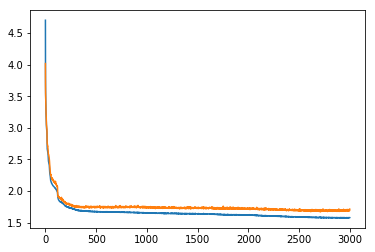

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [336]:
# Sample from Categorical distribution
def sample_mixture(mus, sigs, pis):
    sample = np.random.multinomial(1,pis)
    m = -1
    for idx, val in np.ndenumerate(sample):
        if val == 1:
            m = idx[0]
    return(np.random.normal(mus[m],sigs[m],1))

def split_mixture_params(params, mixtures, dim):
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[2*mixtures*dim:]
    return mus,sigs,pis

def adjust_temp(pi_pdf, temp):
    """ Adjusts temperature of a PDF describing a categorical model """
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a categorical model PDF, optionally greedily."""
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1

def sample_from_categorical(dist, temp):
    r = np.random.rand(1)
    return get_pi_idx(r,dist,temp)

def sample_from_output(params, mixtures, dim):
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[-mixtures:]
    m = sample_from_categorical(pis, temp=6.0)
    #m = np.random.choice(range(len(pis)), p=pis)
    #print(m)
    return(np.random.normal(mus[m],sigs[m],1))

Testing: 3000 samples.


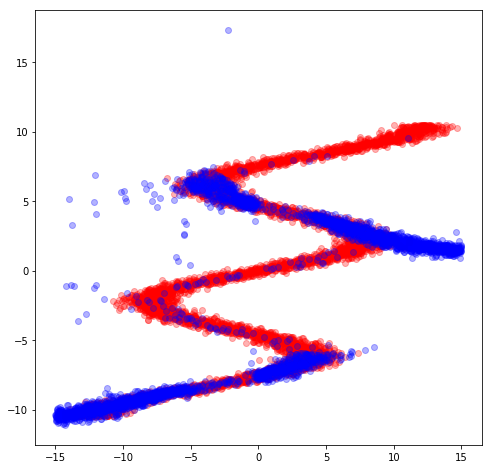

In [337]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector
y_test = model.predict(x_test)
y_samples = np.apply_along_axis(sample_from_output, 1, y_test, 10,1)
means = np.apply_along_axis((lambda a: a[:10]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[10:20]),1, y_test)
pis = np.apply_along_axis((lambda a: a[20:]),1, y_test)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples, 'bo',alpha=0.3)
plt.show()

In [77]:
a_y = model.predict(np.array([0]))

In [151]:
a_y[0][-10:]

array([  4.99393018e-12,   1.82962478e-12,   7.16496107e-15,
         9.99960542e-01,   2.23366112e-13,   3.79522021e-12,
         2.06571717e-12,   3.95081261e-05,   1.29881019e-11,
         1.19270967e-12], dtype=float32)

In [322]:
sample_from_output(a_y[0], 10, 1)



3


array([-7.58817641])